## Survival mutations: coefficients/predictions analysis

In this notebook, we want to look a bit closer at what features are being selected in the predictions -> survival analysis, to get an idea of which genes are used by the model and what their predictions look like.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.data_utilities as du

%load_ext autoreload
%autoreload 2

In [2]:
# set results directories
results_dir = Path(cfg.results_dirs['survival'], 'mutations_me_all')

# set list of PCA component numbers to look for
n_pcs = 10

In [3]:
# order to plot data types in
training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
    'vogelstein_mutations': 'all Vogelstein mutations',
    'significant_mutations': 'significant mutations',
    'mutation_preds_expression': 'mutation scores, expression',
    'mutation_preds_me_27k': 'mutation scores, 27k',
    'mutation_preds_me_450k': 'mutation scores, 450k',
}

### Pan-cancer models

In [4]:
def is_feature_covariate(features):
    # Label "covariate" features (i.e. features that are not derived
    # from -omics data; this includes cancer type indicators and
    # clinical features such as age)
    sample_info_df = du.load_sample_info('expression')
    cancer_types = list(sample_info_df.cancer_type.unique())
    covariate_names = cancer_types + ['age', 'log10_mut']
    return [(f in covariate_names) for f in features]

In [5]:
cancer_type = 'pancancer'
training_data = 'mutation_preds_expression'
seed = 42
fold = 0

coefs_file = '{}_{}_signal_survival_s{}_coefficients.tsv.gz'.format(
    cancer_type, training_data, seed)
coefs_file = results_dir / coefs_file

coefs_df = pd.read_csv(coefs_file, sep='\t')
coefs_df = coefs_df.loc[coefs_df.fold == fold, :].copy()
coefs_df['is_covariate'] = is_feature_covariate(coefs_df.feature)
coefs_df.head()

,feature,weight,abs,signal,seed,identifier,training_data,fold,is_covariate
0,LAML,1.51900,1.51900,signal,42,pancancer,mutation_preds_expression,0,True
1,LGG,1.15840,1.15840,signal,42,pancancer,mutation_preds_expression,0,True
2,GBM,1.10450,1.10450,signal,42,pancancer,mutation_preds_expression,0,True
3,MESO,1.09220,1.09220,signal,42,pancancer,mutation_preds_expression,0,True
4,BRCA,-0.89689,0.89689,signal,42,pancancer,mutation_preds_expression,0,True


In [6]:
coefs_df[coefs_df.is_covariate].head()

,feature,weight,abs,signal,seed,identifier,training_data,fold,is_covariate
0,LAML,1.51900,1.51900,signal,42,pancancer,mutation_preds_expression,0,True
1,LGG,1.15840,1.15840,signal,42,pancancer,mutation_preds_expression,0,True
2,GBM,1.10450,1.10450,signal,42,pancancer,mutation_preds_expression,0,True
3,MESO,1.09220,1.09220,signal,42,pancancer,mutation_preds_expression,0,True
4,BRCA,-0.89689,0.89689,signal,42,pancancer,mutation_preds_expression,0,True


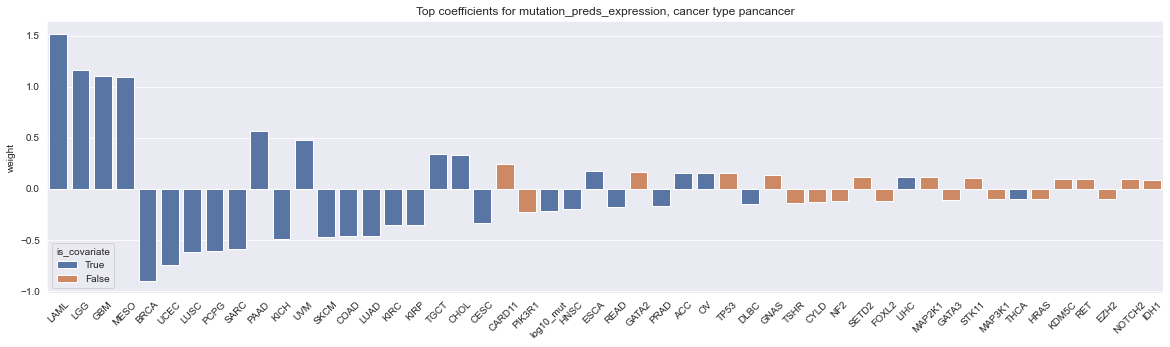

In [7]:
sns.set({'figure.figsize': (20, 5)})

plot_df = (coefs_df
    .sort_values(by='abs', ascending=False)
    .iloc[:50, :]
    .reset_index()
)

sns.barplot(data=plot_df, x=plot_df.index, y=plot_df.weight,
            dodge=False, hue='is_covariate', hue_order=[True, False])
plt.title('Top coefficients for {}, cancer type {}'.format(training_data, cancer_type))
plt.gca().set_xticklabels(plot_df.feature)
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(45)

In [8]:
data_type = training_data.replace('mutation_preds_', '')

predictions_file = cfg.predictions[data_type]
preds_df = pd.read_csv(predictions_file, sep='\t', index_col=0)
preds_df.index.rename('sample_id', inplace=True)
print(preds_df.shape)
preds_df.head()

(7706, 124)


,ABL1,ACVR1B,AKT1,ALK,APC,AR,ARID1A,ARID1B,ARID2,ASXL1,...,STK11,TET2,TNFAIP3,TRAF7,TP53,TSC1,TSHR,U2AF1,VHL,WT1
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-05-4390-01,-0.371785,0.576524,7.396774,-0.070552,0.191976,-0.505655,0.301542,0.408099,0.425224,-1.208974,...,3.927658,-0.345527,0.592601,-0.026505,-2.110181,-2970.946857,-3421.047711,-3.877373,-1.741327,24979.287734
TCGA-05-4410-01,-0.411587,-0.200349,2.518182,0.069179,0.127696,-0.568157,0.299046,0.737339,0.986697,-3.765194,...,1.278944,-1.593844,0.623866,0.285600,3.051560,-402.672882,4445.153328,-4.427424,-1.936559,18339.847553
TCGA-05-5425-01,-0.491071,0.690562,-33.671128,1.351261,0.730346,-0.584281,-0.083572,0.949516,1.148314,0.466511,...,3.078715,-2.810013,0.400344,0.698950,1.525462,1326.352312,3693.727662,-9.268360,-1.368198,91894.043404
TCGA-05-5715-01,-0.328874,0.354758,7.194172,0.287369,0.159284,-0.829824,0.169751,0.688223,0.771709,-2.090697,...,0.965498,-4.962660,0.038166,0.125768,-0.638969,2217.938654,-3051.786624,-2.336121,-1.275989,-170432.482914
TCGA-06-0125-01,-0.319524,-0.375433,4.977411,-0.762433,-0.906999,-0.143099,-0.776910,-0.732178,0.192861,-0.752569,...,-2.161470,-5.448781,-0.863999,-1.822072,0.374619,1329.104493,-8257.175776,-5.816368,-1.376579,-66866.712371


In [9]:
pancan_data = du.load_pancancer_data(verbose=True)
mutation_df = pancan_data[1]
print(mutation_df.shape)
mutation_df.iloc[:5, :5]

Loading pan-cancer data from cached pickle file...


(9074, 20938)


,5S_rRNA,A1BG,A1CF,A2M,A2ML1
SAMPLE_BARCODE,,,,,
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,0,0,0,0,0
TCGA-02-2483-01,0,0,0,0,0
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


In [10]:
gene = 'CARD11'
plot_df = preds_df[[gene]].merge(mutation_df[[gene]],
                                 left_index=True, right_index=True)
plot_df.rename(columns={'{}_x'.format(gene): 'pred_scores',
                        '{}_y'.format(gene): 'is_mutated'},
               inplace=True)
plot_df['pred_prob'] = 1 / (1 + np.exp(-plot_df.pred_scores))
print(plot_df.shape)
print(plot_df.pred_prob.min())
print(plot_df.pred_prob.max())
plot_df.head()

(7706, 3)
0.05519418800668745
0.9855352919436822


,pred_scores,is_mutated,pred_prob
TCGA-05-4390-01,1.096405,0,0.749586
TCGA-05-4410-01,1.002815,0,0.731612
TCGA-05-5425-01,1.568060,1,0.827507
TCGA-05-5715-01,0.788314,0,0.687469
TCGA-06-0125-01,-0.041325,0,0.489670


Text(0, 0.5, 'Predicted mutation probability')

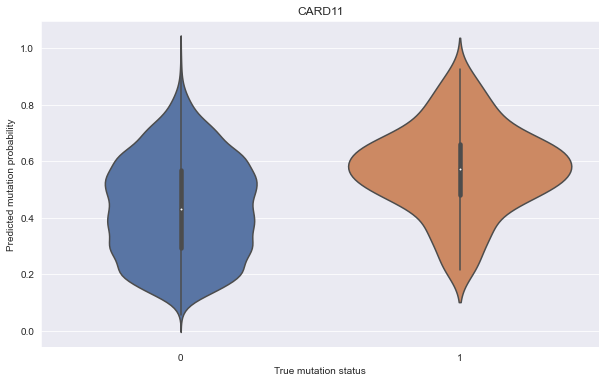

In [11]:
sns.set({'figure.figsize': (10, 6)})
sns.violinplot(data=plot_df, x='is_mutated', y='pred_prob')
plt.title(gene)
plt.xlabel('True mutation status')
plt.ylabel('Predicted mutation probability')

CARD11 is the most predictive gene feature for some of the pan-cancer prediction models - it's interesting to see that the model is not very confident in its predictions (lots of overlap for the score distributions for true positives and true negatives).

Not sure why this would be an informative feature, biologically - maybe a question for future work.